# SMS Spam Detection

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sms-spam-collection-dataset


In [ ]:
!ls /kaggle/input/sms-spam-collection-dataset

spam.csv


In [ ]:
#Importing libraries for preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

#Importing libraries for model training and testing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [ ]:
#Detecting the character set since directly reading via pandas leads to an error
import chardet

with open('/kaggle/input/sms-spam-collection-dataset/spam.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))
    print(result)

{'encoding': 'Windows-1252', 'confidence': 0.7261670208776098, 'language': ''}


In [ ]:
#Reading the csv file with the correct characterset and only keeping the 1st 2 columns since the others are irrelevant
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding = "Windows-1252")
df = df.iloc[:, :2]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


###Data preprocessing

In [ ]:
df.isna().sum()

,0
v1,0
v2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.duplicated().sum()

np.int64(403)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df.rename(columns = {"v1":"Target","v2":"Text"})
df.Target.value_counts() #This is an imbalanced dataset

,count
Target,
ham,4516
spam,653


In [ ]:
#Removing stopwords and any irregular characters from the dataset
nltk.download("stopwords")
stopwords = set(stopwords.words('english'))

def clean_text(text):
  text = text.lower()
  text = re.sub(r"^0-9a-zA-Z","",text) #Removing irregular characters
  text = re.sub(r"\s+"," ",text) #Removing extra spaces
  text = " ".join(word for word in text.split() if word not in stopwords) #Removing stopwords
  return text

df['Clean_text'] = df['Text'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Target,Text,Clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah think goes usf, lives around though"


### Data Visualization

(np.float64(-0.5), np.float64(4999.5), np.float64(2499.5), np.float64(-0.5))

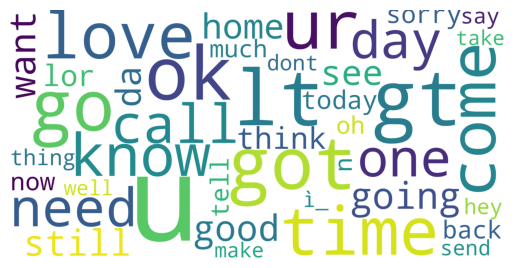

In [ ]:
#Creating a wordcloud of all the words in Spam and Ham classes to assess occurence of words and spot patterns.
from wordcloud import WordCloud
ham_dataset = " | ".join(i for i in df.loc[df['Target'] == 'ham','Clean_text']) #Merging all the ham text into a single variable
ham_dataset[:1000] #printing

wc = WordCloud(background_color = 'white', max_words = 40, width = 5000, height = 2500).generate(ham_dataset)
plt.imshow(wc)
plt.axis('off')

(np.float64(-0.5), np.float64(4999.5), np.float64(2499.5), np.float64(-0.5))

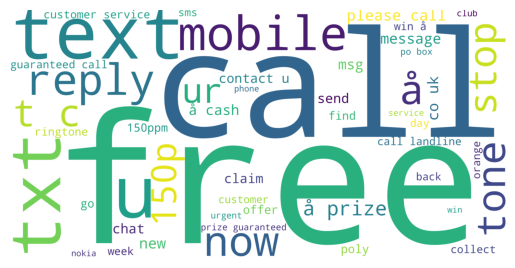

In [ ]:
#Creating a wordcloud of all the words in Spam and Ham classes to assess differences.
spam_dataset = " | ".join(i for i in df.loc[df['Target'] == 'spam','Clean_text'])
spam_dataset[:1000]

wc = WordCloud(background_color = 'white', max_words = 50, width = 5000, height = 2500).generate(spam_dataset)
plt.imshow(wc)
plt.axis('off')

### Model Creation A (Without cross-validation)

In [ ]:
#Creating a function to take the model and input data, fit a pipeline model on it and evaluate it
def classify(model, x, y):
  xtrain, xtest, ytrain, ytest = train_test_split(x,y, random_state = 42, stratify = y, test_size = 0.25)

  #Creating a pipeline to convert the data into a TF-IDF sparse matrix and then fit the model on that data.
  pipeline_model = Pipeline([
      ('tfidf', TfidfVectorizer()),
       ('model', model)])

  pipeline_model.fit(xtrain, ytrain)

  ypred = pipeline_model.predict(xtest)
  print("Classification reports: \n\n", classification_report(ytest, ypred))
  acc = pipeline_model.score(xtest, ytest)*100
  print("Accuracy: ", acc)

In [ ]:
#Splitting the dataset
x = df['Clean_text']
y = df['Target']

In [ ]:
#Checking the performance of the Multinomial Naive Bayes model (It should provide a good performance since the classifier is majorly used for text classification)
model = MultinomialNB(alpha = 0.1)
classify(model, x, y)

Classification reports: 

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1130
        spam       0.97      0.89      0.93       163

    accuracy                           0.98      1293
   macro avg       0.98      0.94      0.96      1293
weighted avg       0.98      0.98      0.98      1293

Accuracy:  98.2985305491106


In [ ]:
#Checking performance of Logistic Regression model
model = LogisticRegression()
classify(model, x, y)

Classification reports: 

               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1130
        spam       0.98      0.66      0.79       163

    accuracy                           0.96      1293
   macro avg       0.97      0.83      0.88      1293
weighted avg       0.96      0.96      0.95      1293

Accuracy:  95.59164733178655


### Model Creation B (With cross-validation)

In [ ]:
#Creating a dictionary of all the models and the parameters to tune
models = {
    'Decision Tree':DecisionTreeClassifier(),
    'SVC':SVC(),
    'Logistic Regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(metric = 'cosine'),
    'Random Forest':RandomForestClassifier(),
    'Naive Bayes':MultinomialNB()
}

params = {
    'Decision Tree':{},
    'SVC':{'kernel':['linear','poly','rbf']},
    'Logistic Regression':{},
    'KNN':{'n_neighbors':[5,10,25,50]},
    'Random Forest':{'n_estimators':[25,50,100]},
    'Naive Bayes':{'alpha':[0,0.1,0.5,1]}
}

# Adding a prefix to the parameter name so that the pipeline reads it as parameter for the internal model. Read the sklearn documentation for further clarification
def add_prefix(d, prefix):
    return {f'{prefix}__{k}': v for k, v in d.items()}

#Creating the function similar to classify() embedded with cross validation capability
def classify_cross_val(x,y):
  xtrain, xtest, ytrain, ytest = train_test_split(x,y, random_state = 42, stratify = y, test_size = 0.25)

  #Looping through all the models with their hyperparameters to tune
  for model, param in zip(models.values(), params.values()):
    pipeline_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)])

    #Appending the prefix to the parameters
    param_grid = add_prefix(param, 'model')
    cv = GridSearchCV(pipeline_model, param_grid = param_grid)
    cv.fit(xtrain, ytrain)

    print(f"For {model}, best params: {cv.best_estimator_}, accuracy: {cv.best_score_}\n\n")

In [ ]:
classify_cross_val(x,y)

For DecisionTreeClassifier(), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', DecisionTreeClassifier())]), accuracy: 0.9491745926172264


For SVC(), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', SVC(kernel='linear'))]), accuracy: 0.9821988693049551


For LogisticRegression(), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', LogisticRegression())]), accuracy: 0.9548496840705021


For KNeighborsClassifier(metric='cosine'), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', KNeighborsClassifier(metric='cosine'))]), accuracy: 0.9636222148320586


For RandomForestClassifier(), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', RandomForestClassifier(n_estimators=25))]), accuracy: 0.9723940804788826


For MultinomialNB(), best params: Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))]), accuracy: 0.

### Creating text embeddings and evaluating model performance to understand improvement or degradation


In [ ]:
#Importing the module and creating the embeddings
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
text_embeddings = model.encode(df['Clean_text'].tolist(), convert_to_numpy = True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Saving the embeddings to avoid recalculations and instead, just loading them from disk for future use
import pickle
with open('bert_embeddings.pkl','wb') as file:
  pickle.dump(text_embeddings, file)

In [ ]:
#Encoding the target labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(encoder.inverse_transform([0,1])) #Identifying how encoding was done for each label (spam and ham)

xtrain, xtest, ytrain, ytest = train_test_split(text_embeddings, y_encoded, test_size = 0.25, random_state = 42)

['ham' 'spam']


In [ ]:
#Normalizing the embeddings since we want to use cosine similarity as the distance measure
from sklearn.preprocessing import normalize

xtrain = normalize(xtrain)
xtest = normalize(xtest)

In [ ]:
#Working with ScaNN from Google for similarity search
!pip install scann
import scann

#Building the SCaNN index
"""
dot_product = using cosine similarity
.tree = partitioning the dataset into clusters or lookup tables
num_leaves = number of clusters
num_leaves_to_search = number of leaves to examine for the final result. Accuracy and speed tradeoff

.score_ah = Used to speed up similarity computation
2 = number of bytes to consider for hashing per dimension
anisotropic_quantization_threshold=0.2  = Controls how much precision is allowed to vary across dimensions.

.reorder = Reorder to find the top 100 results from searching,
build = Building the whole index
"""

searcher = scann.scann_ops_pybind.builder(xtrain, 10, "dot_product").tree(num_leaves = 200, num_leaves_to_search = 100, training_sample_size = 25000).score_ah(2, anisotropic_quantization_threshold = 0.2).reorder(100).build()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.0 MB/s eta 0:00:00


In [ ]:
ypred = []

for test_vec in xtest:
  neighbors, distances = searcher.search(test_vec, final_num_neighbors = 5) #Search for 5 neighbors for each vector in test set
  neighbor_labels = ytrain[neighbors] #Getting the labels of the neighbors
  prediction = int(np.round(np.mean(neighbor_labels))) #Averaging the labels of the neighbors and rounding it up as the final result
  ypred.append(prediction) #Storing it in the ypred list

In [ ]:
#Evaluating results
acc = accuracy_score(ytest, ypred)
print("Accuracy: ", acc)

print("Classification Report: \n", classification_report(ytest, ypred))

Accuracy:  0.9737045630317092
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1107
           1       0.90      0.92      0.91       186

    accuracy                           0.97      1293
   macro avg       0.94      0.95      0.95      1293
weighted avg       0.97      0.97      0.97      1293



In [ ]:
#Trying KNN for these text embeddings
knn = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', metric = 'cosine')
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtest)

acc = accuracy_score(ytest, ypred)
print("Accuracy: ", acc)

print("Classification Report: \n", classification_report(ytest, ypred))

Accuracy:  0.9783449342614076
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1107
           1       0.90      0.95      0.93       186

    accuracy                           0.98      1293
   macro avg       0.95      0.97      0.96      1293
weighted avg       0.98      0.98      0.98      1293

